---
# This notebook is intended to demonstrate how to model a simple optical cavity in Python
---
<div style="text-align: right"> Written by Lane Scheel, 2024 </div>

## First I will construct an optical cavity in the popular modeling software FINESSE
### - This will be used to compare the results of my model to those of an established software

In [1]:
import finesse
import numpy as np
import matplotlib.pyplot as plt
finesse.configure(plotting=True)

kat = finesse.Model()
kat.parse(
    """
    # Add a Laser named L0 with a power of 1 W and wavelength of 1064nm
    l L0 P=1

    # Space attaching L0 <-> m1 with length of 0 m (default).
    s s0 L0.p1 m1.p1

    # Input mirror of cavity.
    m m1 R=0.99 T=0.01

    # Intra-cavity space with length of 1 m.
    s CAV m1.p2 m2.p1 L=1

    # End mirror of cavity.
    m m2 R=0.99 T=0.01

    # Power detectors on circulation and transmission.
    ad circ m2.p1.i f=0
    ad trns m2.p2.o f=0

    xaxis(m2.phi, lin, -180, 180, 10000)
    """
)

out = kat.run()

## Now I will create my own function that serves as an optical cavity constructor
### - This should yield the same results as the FINESSE model

In [2]:
def optical_cavity(R1, R2, T1, T2, D, phi, P0):

    # Define the wavelength of the laser in meters
    w = 1064e-9  # meters

    # Calculate the wavenumber k in inverse meters
    k = 2 * np.pi / w  # 1/meters

    # Convert given mirror coefficients
    t1 = np.sqrt(T1)  # unitless
    t2 = np.sqrt(T2)  # unitless
    r1 = np.sqrt(R1)  # unitless
    r2 = np.sqrt(R2)  # unitless

    # Define the variable length of the cavity in meters
    d_range = np.linspace(-(phi / 360) * w, (phi / 360) * w, 10000)

    # Convert the d_range to a phi_range
    phi_range = (-d_range) * (360 / w)
    E0 = np.sqrt(P0)
    
    # Calculate the circulating amplitude in the optical cavity
    a_circ = E0 * (
        (1j * t1)
        / (1 - r1 * r2 * np.exp(-1j * 2 * k * d_range))
    )

    # Calculate the transmitted amplitude through the optical cavity
    a_trans = 1j * t2 * a_circ

    return phi_range, a_trans, a_circ

## We can now call my function with the same parameters as the FINESSE model

In [3]:
phi_range, a_trans, a_circ = optical_cavity(R1=0.99, R2=0.99, T1=0.01, T2=0.01, D=1, phi=180, P0=1)

## Now we will plot the results over the top of one another to see how they compare

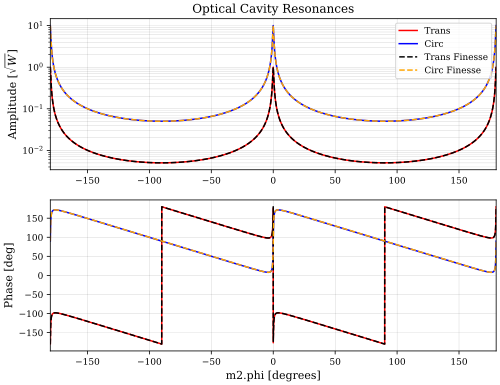

In [4]:
# Make plots
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
ax = axes[0]
ax.set_title("Optical Cavity Resonances")
ax.plot(phi_range, np.abs(a_trans), "r", label="Trans")
ax.plot(phi_range, np.abs(a_circ),  "b", label="Circ")
ax.plot(out.x[0], np.abs(out['trns']), "k", ls='--', label="Trans Finesse")
ax.plot(out.x[0], np.abs(out['circ']),  "orange", ls='--', label="Circ Finesse")
ax.set_ylabel(r"Amplitude [$\sqrt{W}$]")
ax.set_yscale('log')
ax.legend()
ax = axes[1]
ax.plot(phi_range, np.angle(a_trans, deg=True), "r", label="Trans")
ax.plot(phi_range, np.angle(a_circ, deg=True) , "b", label="Circ")
ax.plot(out.x[0], np.angle(out['trns'], deg=True), "k", ls='--', label="Trans Finesse")
ax.plot(out.x[0], np.angle(out['circ'], deg=True),  "orange", ls='--', label="Circ Finesse")
ax.set_xlabel(r"m2.phi [degrees]")
ax.set_ylabel("Phase [deg]")
plt.show()

## And we get an exact match! 